## Data Load

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

ACCOUNTS = "data/ravenstack_accounts.csv"
SUBS     = "data/ravenstack_subscriptions.csv"

accts = pd.read_csv(ACCOUNTS, parse_dates=["signup_date"])
subs  = pd.read_csv(SUBS,     parse_dates=["start_date","end_date"])

# Basic hygiene
subs["end_date"] = subs["end_date"].fillna(subs["start_date"].max())
subs["is_paid"]  = (~subs["is_trial"]) & (subs["mrr_amount"].fillna(0) > 0)


## Build account milestones & funnel flags

In [3]:
# First trial period
trial_rows = subs[subs["is_trial"]]
first_trial = (trial_rows.sort_values(["account_id","start_date"])
               .groupby("account_id", as_index=False)
               .first()[["account_id","start_date","end_date"]]
               .rename(columns={"start_date":"trial_start","end_date":"trial_end"}))

# First paid start
paid_rows = subs[subs["is_paid"]]
first_paid = (paid_rows.sort_values(["account_id","start_date"])
              .groupby("account_id", as_index=False)
              .first()[["account_id","start_date","mrr_amount","seats","plan_tier"]]
              .rename(columns={"start_date":"paid_start",
                               "mrr_amount":"first_paid_mrr",
                               "seats":"first_paid_seats",
                               "plan_tier":"first_paid_tier"}))

# First upgrade event
up_rows = subs[subs["upgrade_flag"]==True]
first_upgrade = (up_rows.sort_values(["account_id","start_date"])
                 .groupby("account_id", as_index=False)
                 .first()[["account_id","start_date"]]
                 .rename(columns={"start_date":"upgrade_date"}))

# Combine
milestones = (accts[["account_id","industry","country","signup_date"]]
              .merge(first_trial, on="account_id", how="left")
              .merge(first_paid, on="account_id", how="left")
              .merge(first_upgrade, on="account_id", how="left"))

# Require paid to occur after trial (if both exist)
mask = (~milestones["trial_start"].isna()) & (~milestones["paid_start"].isna())
milestones.loc[mask & (milestones["paid_start"] < milestones["trial_start"]), "paid_start"] = pd.NaT

# Windowed definitions
milestones["paid_within_90d"] = False
sel = (~milestones["trial_start"].isna()) & (~milestones["paid_start"].isna())
milestones.loc[sel, "paid_within_90d"] = (milestones.loc[sel, "paid_start"] - milestones.loc[sel, "trial_start"] <= pd.Timedelta(days=90))

milestones["upgrade_within_180d"] = False
sel2 = (~milestones["paid_start"].isna()) & (~milestones["upgrade_date"].isna())
milestones.loc[sel2, "upgrade_within_180d"] = (milestones.loc[sel2, "upgrade_date"] - milestones.loc[sel2, "paid_start"] <= pd.Timedelta(days=180))

# Time deltas
milestones["days_trial_to_paid"]   = (milestones["paid_start"] - milestones["trial_start"]).dt.days
milestones["days_paid_to_upgrade"] = (milestones["upgrade_date"] - milestones["paid_start"]).dt.days

# Flags
milestones["in_trial_cohort"]   = ~milestones["trial_start"].isna()
milestones["converted_to_paid"] = ~milestones["paid_start"].isna()
milestones["upgraded"]          = ~milestones["upgrade_date"].isna()

# Composite indicator for overall path
milestones["trial_to_upgrade_path"] = milestones["paid_within_90d"] & milestones["upgrade_within_180d"]

milestones.head()


,account_id,industry,country,signup_date,trial_start,trial_end,paid_start,first_paid_mrr,first_paid_seats,first_paid_tier,upgrade_date,paid_within_90d,upgrade_within_180d,days_trial_to_paid,days_paid_to_upgrade,in_trial_cohort,converted_to_paid,upgraded,trial_to_upgrade_path
0,A-2e4581,EdTech,US,2024-10-16,2024-10-30,2024-12-31,NaT,441,9,Pro,2024-11-17,False,False,NaN,NaN,True,False,True,False
1,A-43a9e3,FinTech,IN,2023-08-17,NaT,NaT,2023-09-20,418,22,Basic,2023-11-06,False,True,NaN,47.0,False,True,True,False
2,A-0a282f,DevTools,US,2024-08-27,2024-12-25,2024-12-28,NaT,3781,19,Enterprise,2024-10-23,False,False,NaN,NaN,True,False,True,False
3,A-1f0ac7,HealthTech,UK,2023-08-27,2024-07-11,2024-12-31,NaT,1176,24,Pro,2024-07-11,False,False,NaN,NaN,True,False,True,False
4,A-ce550d,HealthTech,US,2024-10-27,2024-11-13,2024-12-31,NaT,6965,35,Enterprise,2024-10-28,False,False,NaN,NaN,True,False,True,False


## Aggregate funnel by industry

In [4]:
def pct_mean(series):
    return 100.0 * series.mean() if len(series) else np.nan

funnel = (milestones.groupby("industry")
          .agg(accounts=("account_id","nunique"),
               trial_accounts=("in_trial_cohort","sum"),
               trial_to_paid_rate=("paid_within_90d", pct_mean),
               paid_accounts=("converted_to_paid","sum"),
               paid_to_upgrade_rate=("upgrade_within_180d", pct_mean),
               overall_trial_to_upgrade_rate=("trial_to_upgrade_path", pct_mean),
               med_days_trial_to_paid=("days_trial_to_paid", lambda s: np.nanmedian(s)),
               med_days_paid_to_upgrade=("days_paid_to_upgrade", lambda s: np.nanmedian(s)),
               first_paid_mrr=("first_paid_mrr", lambda s: np.nanmean(s)),
               first_paid_seats=("first_paid_seats", lambda s: np.nanmean(s)))
          .reset_index()
          .sort_values("overall_trial_to_upgrade_rate", ascending=False))

funnel


,industry,accounts,trial_accounts,trial_to_paid_rate,paid_accounts,paid_to_upgrade_rate,overall_trial_to_upgrade_rate,med_days_trial_to_paid,med_days_paid_to_upgrade,first_paid_mrr,first_paid_seats
0,Cybersecurity,100,76,16.000000,43,25.000000,12.000000,19.0,20.0,2778.200000,31.100000
4,HealthTech,96,77,17.708333,38,21.875000,10.416667,36.0,55.5,3037.166667,28.666667
3,FinTech,112,88,11.607143,39,14.285714,6.250000,33.0,65.0,2675.303571,30.589286
1,DevTools,113,95,17.699115,40,14.159292,6.194690,9.0,37.0,2035.982301,26.938053
2,EdTech,79,67,18.987342,29,10.126582,5.063291,36.0,93.0,2991.810127,35.025316


## Overall funnel (all industries combined)

In [5]:
overall = (milestones.assign(industry="All")
           .groupby("industry")
           .agg(accounts=("account_id","nunique"),
                trial_accounts=("in_trial_cohort","sum"),
                trial_to_paid_rate=("paid_within_90d", pct_mean),
                paid_accounts=("converted_to_paid","sum"),
                paid_to_upgrade_rate=("upgrade_within_180d", pct_mean),
                overall_trial_to_upgrade_rate=("trial_to_upgrade_path", pct_mean),
                med_days_trial_to_paid=("days_trial_to_paid", lambda s: np.nanmedian(s)),
                med_days_paid_to_upgrade=("days_paid_to_upgrade", lambda s: np.nanmedian(s)),
                first_paid_mrr=("first_paid_mrr", lambda s: np.nanmean(s)),
                first_paid_seats=("first_paid_seats", lambda s: np.nanmean(s)))
           .reset_index())

overall


,industry,accounts,trial_accounts,trial_to_paid_rate,paid_accounts,paid_to_upgrade_rate,overall_trial_to_upgrade_rate,med_days_trial_to_paid,med_days_paid_to_upgrade,first_paid_mrr,first_paid_seats
0,All,500,403,16.2,189,17.2,8.0,22.5,47.0,2670.882,30.198


## plots

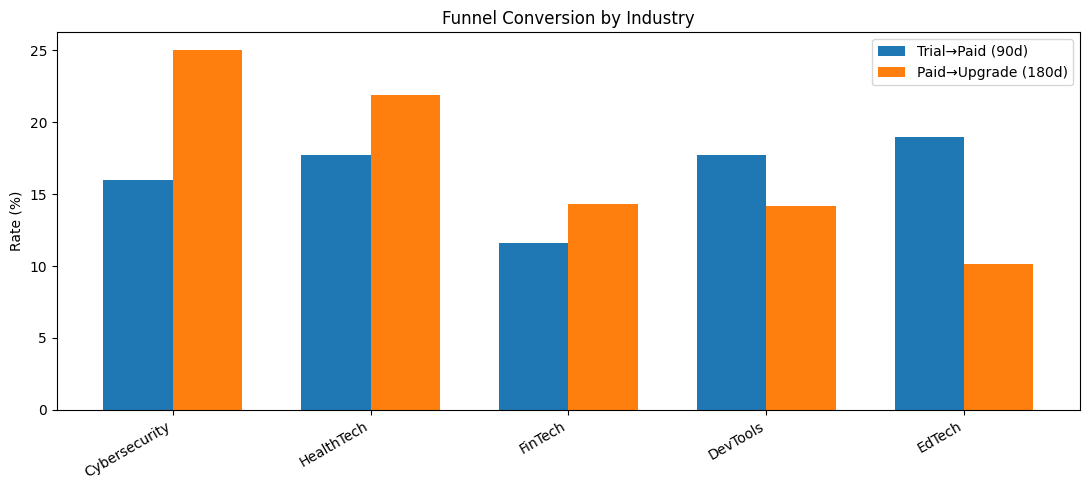

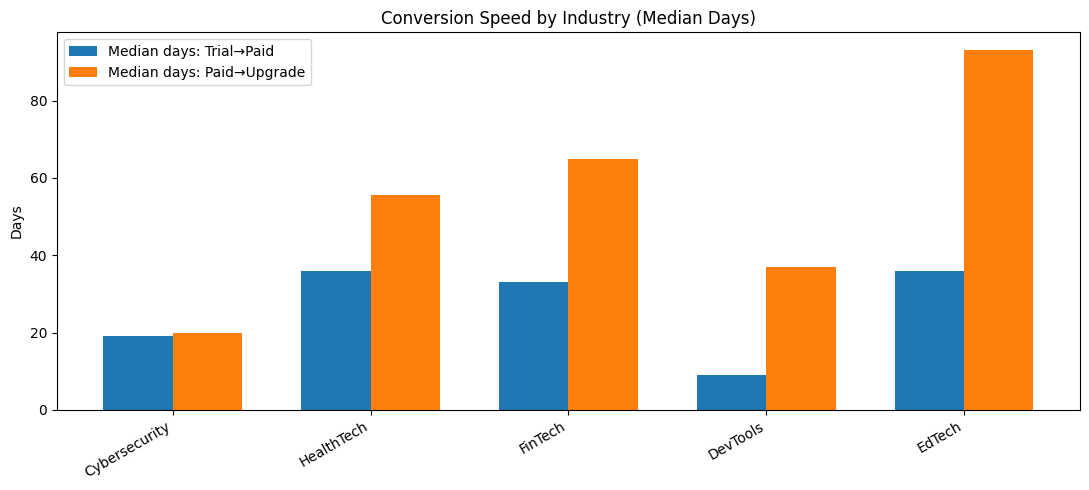

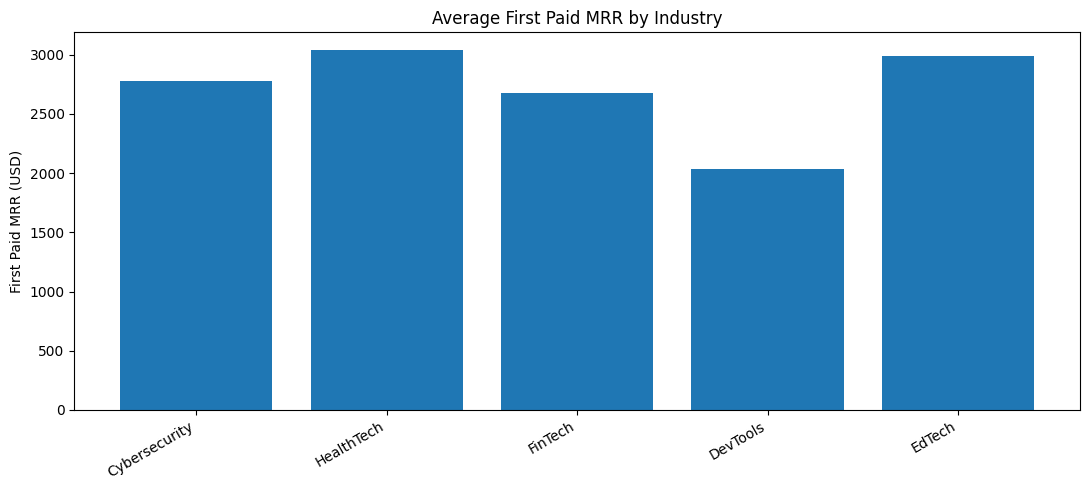

In [6]:
# recreate index
ind = np.arange(len(funnel))
width = 0.35

# ---------- Plot 1: Funnel Conversion (Trial→Paid / Paid→Upgrade) ----------
plt.figure(figsize=(11,5))
plt.bar(ind - width/2, funnel["trial_to_paid_rate"], width, label="Trial→Paid (90d)")
plt.bar(ind + width/2, funnel["paid_to_upgrade_rate"], width, label="Paid→Upgrade (180d)")
plt.xticks(ind, funnel["industry"], rotation=30, ha="right")
plt.ylabel("Rate (%)")
plt.title("Funnel Conversion by Industry")
plt.legend()
plt.tight_layout()
plt.savefig("funnel_conversion_by_industry.png", dpi=300, bbox_inches='tight')
plt.show()

# ---------- Plot 2: Conversion Speed (Median Days) ----------
plt.figure(figsize=(11,5))
plt.bar(ind - width/2, funnel["med_days_trial_to_paid"], width, label="Median days: Trial→Paid")
plt.bar(ind + width/2, funnel["med_days_paid_to_upgrade"], width, label="Median days: Paid→Upgrade")
plt.xticks(ind, funnel["industry"], rotation=30, ha="right")
plt.ylabel("Days")
plt.title("Conversion Speed by Industry (Median Days)")
plt.legend()
plt.tight_layout()
plt.savefig("conversion_speed_by_industry.png", dpi=300, bbox_inches='tight')
plt.show()

# ---------- Plot 3: First Paid MRR by Industry ----------
plt.figure(figsize=(11,5))
plt.bar(ind, funnel["first_paid_mrr"])
plt.xticks(ind, funnel["industry"], rotation=30, ha="right")
plt.ylabel("First Paid MRR (USD)")
plt.title("Average First Paid MRR by Industry")
plt.tight_layout()
plt.savefig("first_paid_mrr_by_industry.png", dpi=300, bbox_inches='tight')
plt.show()
